In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ijson
import seaborn as sns

In [6]:
# File path
input_filename = "6386d89efb3ff533c12df167__post10.json"
file_path = os.path.join("/Users/MonicaChan/Desktop/wu-lab/data_tutorial/11-30-2022/", input_filename)

# Storage for 3,000 westbound trajectories
westbound_trajectories = []
t_min = 0  # Initialize to latest possible timestamp
t_max = 0  # Initialize to earliest possible timestamp
set_min_time = False

# Open file and stream data
with open(file_path, "r") as f:
    trajectory_iterator = ijson.items(f, "item")  # Assuming JSON is a list of trajectories
    for i,traj in enumerate(trajectory_iterator):
        # df["timestamp"] = df["timestamp"].astype("float")
        # df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
        
        
        x_positions = traj.get("x_position", [])

        # Ensure we have enough points to determine direction
        if len(x_positions) > 1:
            if x_positions[-1] < x_positions[0]:  # Check if x is decreasing over time
                westbound_trajectories.append(traj)
                timestamps = [float(num) for num in traj.get("timestamp")]
                timestamps = pd.to_datetime(timestamps, unit = "s")
                if not set_min_time:
                    t_min = timestamps[0]
                    set_min_time = True
                t_max = timestamps[0]
                if t_max-t_min > pd.Timedelta(minutes=10):
                    print("t max", t_max)
                    print("t min", t_min)
                    break

# Now, we have 3,000 westbound trajectories
print(f"Loaded {len(westbound_trajectories)} westbound trajectories.")

t max 2022-11-30 12:10:00.200000048
t min 2022-11-30 11:59:59.900000095
Loaded 3455 westbound trajectories.


In [7]:
# Flatten westbound trajectories into a DataFrame with trajectory_id
records = []
for traj_id, traj in enumerate(westbound_trajectories):  # Assign unique ID to each trajectory
    # print(traj["timestamp"])
    for i in range(len(traj["timestamp"])):
        records.append({
            "trajectory_id": traj_id,  # Add trajectory ID
            "timestamp": traj["timestamp"][i],
            "x_position": traj["x_position"][i],
            "speed": traj["y_position"][i] if "y_position" in traj else np.nan  # Use real speed if available
        })

print(traj_id)
df = pd.DataFrame(records)
# Convert timestamp to datetime format if not done earlier
df["timestamp"] = df["timestamp"].astype("float")
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
# Debugging: Check column names and first few rows
print(df.columns.tolist())  # Should include 'trajectory_id'
print(df)

3454
['trajectory_id', 'timestamp', 'x_position', 'speed']
        trajectory_id                     timestamp          x_position  \
0                   0 2022-11-30 11:59:59.900000095  315850.09783643583   
1                   0 2022-11-30 11:59:59.940000057   315845.5643252045   
2                   0 2022-11-30 11:59:59.980000019  315841.03489504935   
3                   0 2022-11-30 12:00:00.020000219  315836.50955000444   
4                   0 2022-11-30 12:00:00.060000181   315831.9882974884   
...               ...                           ...                 ...   
466781           3454 2022-11-30 12:10:00.920000076    314644.257617663   
466782           3454 2022-11-30 12:10:00.960000038   314641.0732147664   
466783           3454 2022-11-30 12:10:01.000000000   314637.8814866535   
466784           3454 2022-11-30 12:10:01.040000200  314634.68245173537   
466785           3454 2022-11-30 12:10:01.080000162    314631.476119466   

                     speed  
0       13.

In [8]:

def get_flow_speed_matrix(time_interval = pd.Timedelta(minutes=1), space_interval = 100):
    # Define grid resolution
    
    # Compute min/max for time and space
    t_min, t_max = df["timestamp"].min(), df["timestamp"].max()
    x_min, x_max = df["x_position"].min(), df["x_position"].max()
    
    # Ensure x_min and x_max are valid
    if x_min == x_max:
        raise ValueError("x_min and x_max are identical, meaning no variation in x_position.")
    
    # Create time bins
    print("tmin", t_min)
    print("tmax", t_max)
    time_bins = pd.date_range(start=t_min, end=t_max, freq=time_interval)
    
    # Create space bins
    space_bins = np.arange(x_min, x_max + space_interval, space_interval)
    
    # Ensure space_bins is not empty
    if len(space_bins) < 2:
        raise ValueError("space_bins array is empty or too small, adjust space_interval.")
    
    # Initialize flow and speed matrices
    flow_matrix = np.zeros((len(time_bins) - 1, len(space_bins) - 1))
    speed_matrix = np.zeros((len(time_bins) - 1, len(space_bins) - 1))
    
    # Assign vehicles to bins and compute metrics
    for i in range(len(time_bins) - 1):
        for j in range(len(space_bins) - 1):
            mask = (
                (df["timestamp"] >= time_bins[i]) & (df["timestamp"] < time_bins[i + 1]) &
                (df["x_position"] >= space_bins[j]) & (df["x_position"] < space_bins[j + 1])
            )
            cell_data = df[mask]
            
            # Compute flow (count of vehicles)
            flow_matrix[i, j] = len(cell_data)
            
            # Compute speed (average speed per cell, if data exists)
            if not cell_data.empty and "speed" in df.columns:
                speed_matrix[i, j] = cell_data["speed"].mean()
    
    print("flow matrix", flow_matrix)
    print("speed matrix", speed_matrix)
    return flow_matrix, speed_matrix

In [12]:
def plot_matrices(flow_matrix, speed_matrix, time_increment, space_increment): # Plot the flow matrix
    print("min time", t_min)
    print("max time", t_max)
    # print("x_min", x_min)
    # print("x_max", x_max)
    print("flow_matrix shape", flow_matrix.shape)
    print("speed matrix shape", speed_matrix.shape)
    plt.figure(figsize=(12, 6))
    
    # Create heatmap for flow matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(flow_matrix.T, cmap="YlGnBu", xticklabels=False, yticklabels=False, cbar_kws={'label': 'Flow (vehicles)'})
    plt.title(f"Time-Space Diagram of Vehicle Flow {time_increment} meters, {space_increment}")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    
    # Plot the speed matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(speed_matrix.T, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar_kws={'label': 'Average Speed (m/s)'})
    plt.title(f"Time-Space Diagram of Vehicle Speed {time_increment} meters, {space_increment}")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [10]:
# 100m, 1 minute
flow_1min_100m, speed_1min_100m = get_flow_speed_matrix(time_interval = pd.Timedelta(minutes=1), space_interval = 100)

# 100m, 10 sec
flow_10sec_100m, speed_10sec_100m = get_flow_speed_matrix(time_interval = pd.Timedelta(seconds=10), space_interval = 100)


tmin 2022-11-30 11:59:59.900000095
tmax 2022-11-30 12:10:01.080000162
flow matrix [[0.000e+00 0.000e+00 0.000e+00 ... 1.680e+02 1.220e+02 3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 5.700e+01 5.300e+01 1.400e+01]
 [0.000e+00 1.500e+01 3.100e+01 ... 1.070e+02 1.000e+02 2.300e+01]
 ...
 [0.000e+00 1.000e+00 5.300e+01 ... 3.590e+02 3.250e+02 1.060e+02]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.490e+02 1.630e+02 3.400e+01]
 [4.250e+02 1.348e+03 1.568e+03 ... 0.000e+00 0.000e+00 0.000e+00]]
speed matrix [[ 0.          0.          0.         ... 31.09749899 24.51290234
  24.56286715]
 [ 0.          0.          0.         ... 39.88774525 38.47946572
  56.40390828]
 [ 0.         37.84014438 38.64700636 ... 41.00465228 43.24955789
  53.45676118]
 ...
 [ 0.         32.76875015 39.4469377  ... 33.14035915 30.18176702
  23.9261623 ]
 [ 0.          0.          0.         ... 42.78304312 42.44793301
  48.2492825 ]
 [33.08780096 29.59572931 28.3095448  ...  0.          0.
   0.        ]]
tmin 2022-11-

min time 2022-11-30 11:59:59.900000095
max time 2022-11-30 12:10:00.200000048
flow_matrix shape (10, 216)
speed matrix shape (10, 216)


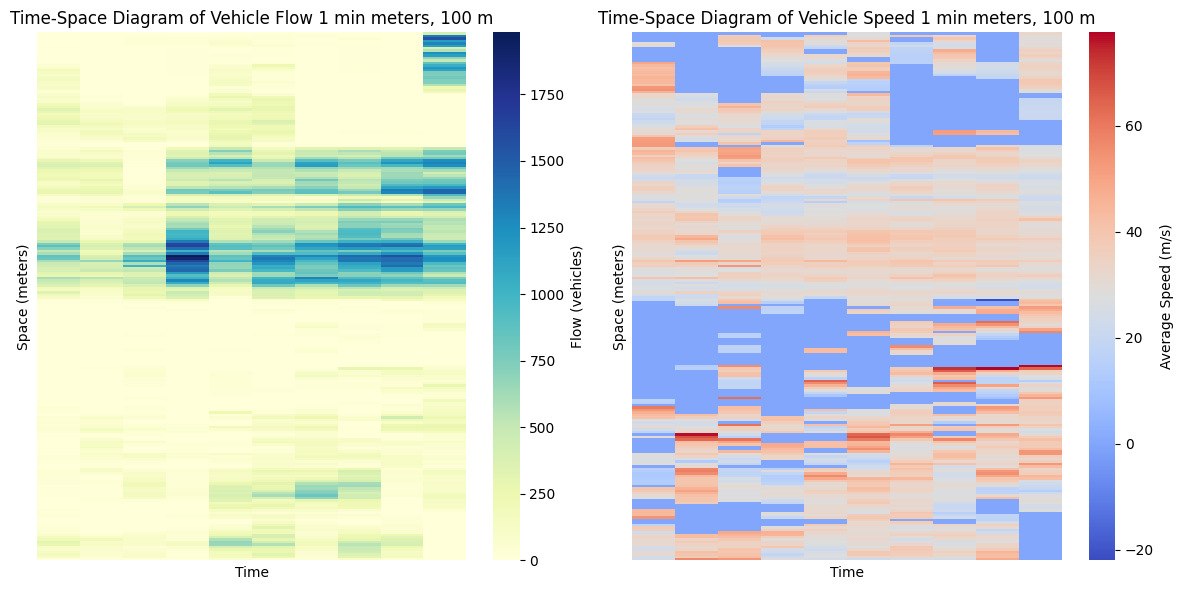

min time 2022-11-30 11:59:59.900000095
max time 2022-11-30 12:10:00.200000048
flow_matrix shape (60, 216)
speed matrix shape (60, 216)


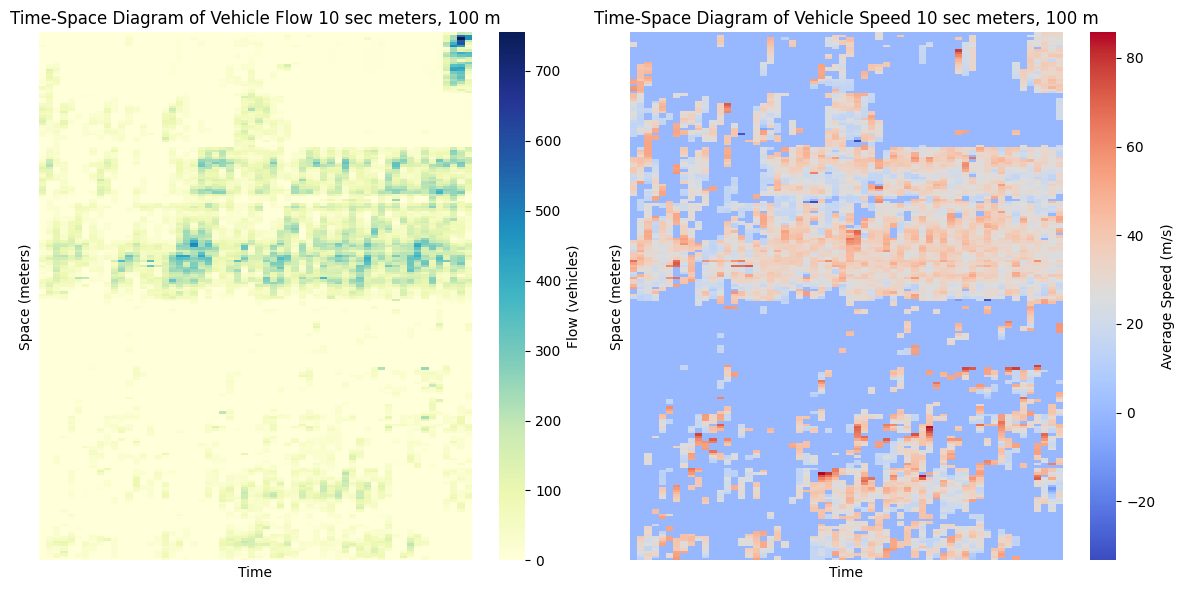

In [13]:
plot_matrices(flow_1min_100m, speed_1min_100m, "1 min", "100 m")
plot_matrices(flow_10sec_100m, speed_10sec_100m, "10 sec", "100 m")